In [35]:
import torch
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor
from torch import nn
from torch.nn import functional as F
from matplotlib import pyplot as plt
from tqdm import tqdm

### Data Loading

In [36]:
train_dataset = CIFAR10('./CIFAR10', download=True, transform=Compose([ToTensor()]), train=True)

test_dataset = CIFAR10('./CIFAR10', download=True, transform=Compose([ToTensor()]), train=False)

Files already downloaded and verified
Files already downloaded and verified


In [37]:
test_dataset[0][0].shape

torch.Size([3, 32, 32])

In [38]:
batch_size = 8192

train_dl = DataLoader(train_dataset, batch_size=batch_size)

test_dl = DataLoader(test_dataset, batch_size=batch_size)

### Metrics

In [59]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def test_model(model):
    test_x = torch.stack([d[0].to('cuda') for d in test_dataset])
    test_y = [d[1] for d in test_dataset]
    
    logits = model(test_x)
    
    likelihoods = torch.softmax(logits, dim=1)
    
    predictions = torch.argmax(likelihoods, dim=-1)
    
    predictions = predictions.cpu().detach().numpy()
    
    valid_loss = F.cross_entropy(logits.to('cpu'), torch.Tensor(test_y).to(torch.long))
    
    precision = precision_score(test_y, predictions, average='micro')
    
    recall = recall_score(test_y, predictions, average='micro')
    
    f1 = f1_score(test_y, predictions, average='micro')
    
    c_m = confusion_matrix(test_y, predictions)
    
    print(f'Validation Loss: {valid_loss}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')
    print(f'Confusion Matrix: ', c_m) # TODO: Print the confusion Matrix Properly
    

### MLP

#### MLP Definition

In [44]:
class SimpleMLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(3 * 1024, 256)
        
        self.fc2 = nn.Linear(256, 32)
        
        self.fc3 = nn.Linear(32, 10)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        
        return x
    
model = SimpleMLP()

model = model.to('cuda')

#### MLP Training

In [54]:
def trainer(model, is_cnn = False):
    optm = torch.optim.Adam(model.parameters(), lr=0.0001)
    
    epochs = 32
    losses = []
    
    loss_acc = 0
    loss_means = []

    for epoch in tqdm(range(1, epochs + 1)): # TODO: Add TQDM
        for s in train_dl:
            x, y = s
            x = x.to('cuda')
            y = y.to('cuda')
            optm.zero_grad()
            
            if is_cnn is False:
                result = model(torch.flatten(x, start_dim=1))
            
            else:
                print(x.shape)
                result = model(x)
            
            loss = F.cross_entropy(result, y)
            
            loss.backward()
            
            optm.step()
            
            losses.append(loss.item())
            
            loss_acc += loss
            loss_means.append((loss_acc / epoch).item())
            

    return (losses, loss_means)

In [46]:
losses, loss_means = trainer(model)

100%|██████████| 256/256 [07:42<00:00,  1.81s/it]


In [20]:
def plot_losses(losses):
    x = range(1, len(losses) + 1)
    y = losses
    
    plt.plot(x, y)

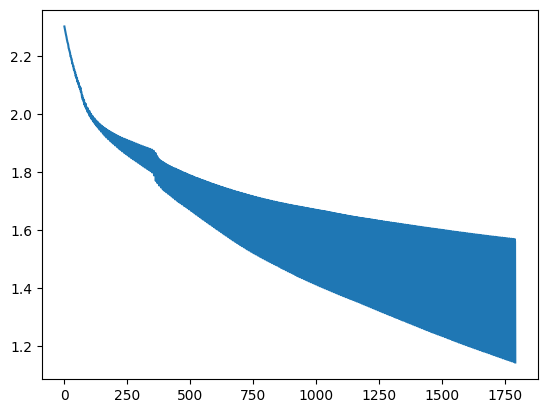

In [47]:
plot_losses(losses)

In [48]:
test_model(model)

Validation Loss: 1.6067991256713867
Precision: 0.4472
Recall: 0.4472
F1 Score: 0.4472
Confusion Matrix:  [[565  44  79  29  33  25   0  38 135  52]
 [ 44 585  15  31  14  33   0  34  69 175]
 [ 93  36 402  96 133 108   0  84  29  19]
 [ 32  32  94 365  63 244   0  71  33  66]
 [ 75  18 181  85 405  75   0 111  30  20]
 [ 31  31 106 216  80 375   0  89  27  45]
 [ 18  33 191 244 232 168   0  58  23  33]
 [ 51  28  54  60  78  88   0 570  16  55]
 [117  69  16  29  15  34   0  20 631  69]
 [ 52 171  11  36  21  30   0  44  61 574]]


### CNN Model

#### Model Definition

In [56]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 32, (3, 3), stride=2)
        self.pool = nn.MaxPool2d((2, 2), stride=1)
        self.conv2 = nn.Conv2d(32, 4, (3, 3), stride=2)
        
        self.mlp = nn.Sequential(nn.Linear(144, 10), nn.ReLU())
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = torch.flatten(x, start_dim=1)
        x = self.mlp(x)
        
        return x
    
model = SimpleCNN()
model = model.to('cuda')

In [57]:
losses, loss_means = trainer(model, True)

  0%|          | 0/32 [00:00<?, ?it/s]

torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])


  3%|▎         | 1/32 [00:01<01:00,  1.96s/it]

torch.Size([8192, 3, 32, 32])
torch.Size([848, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])


  6%|▋         | 2/32 [00:03<00:56,  1.88s/it]

torch.Size([8192, 3, 32, 32])
torch.Size([848, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])


  9%|▉         | 3/32 [00:05<00:54,  1.87s/it]

torch.Size([8192, 3, 32, 32])
torch.Size([848, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])


 12%|█▎        | 4/32 [00:07<00:51,  1.86s/it]

torch.Size([8192, 3, 32, 32])
torch.Size([848, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])


 16%|█▌        | 5/32 [00:09<00:49,  1.85s/it]

torch.Size([8192, 3, 32, 32])
torch.Size([848, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])


 19%|█▉        | 6/32 [00:11<00:48,  1.85s/it]

torch.Size([8192, 3, 32, 32])
torch.Size([848, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])


 22%|██▏       | 7/32 [00:12<00:46,  1.84s/it]

torch.Size([8192, 3, 32, 32])
torch.Size([848, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])


 25%|██▌       | 8/32 [00:14<00:44,  1.84s/it]

torch.Size([8192, 3, 32, 32])
torch.Size([848, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])


 28%|██▊       | 9/32 [00:16<00:42,  1.83s/it]

torch.Size([8192, 3, 32, 32])
torch.Size([848, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])


 31%|███▏      | 10/32 [00:18<00:40,  1.84s/it]

torch.Size([8192, 3, 32, 32])
torch.Size([848, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])


 34%|███▍      | 11/32 [00:20<00:38,  1.83s/it]

torch.Size([8192, 3, 32, 32])
torch.Size([848, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])


 38%|███▊      | 12/32 [00:22<00:36,  1.83s/it]

torch.Size([8192, 3, 32, 32])
torch.Size([848, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])


 41%|████      | 13/32 [00:23<00:34,  1.82s/it]

torch.Size([8192, 3, 32, 32])
torch.Size([848, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])


 44%|████▍     | 14/32 [00:25<00:32,  1.82s/it]

torch.Size([8192, 3, 32, 32])
torch.Size([848, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])


 47%|████▋     | 15/32 [00:27<00:30,  1.82s/it]

torch.Size([8192, 3, 32, 32])
torch.Size([848, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])


 50%|█████     | 16/32 [00:29<00:28,  1.81s/it]

torch.Size([8192, 3, 32, 32])
torch.Size([848, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])


 53%|█████▎    | 17/32 [00:31<00:27,  1.81s/it]

torch.Size([8192, 3, 32, 32])
torch.Size([848, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])


 56%|█████▋    | 18/32 [00:32<00:25,  1.81s/it]

torch.Size([8192, 3, 32, 32])
torch.Size([848, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])


 59%|█████▉    | 19/32 [00:34<00:23,  1.81s/it]

torch.Size([8192, 3, 32, 32])
torch.Size([848, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])


 62%|██████▎   | 20/32 [00:36<00:21,  1.82s/it]

torch.Size([8192, 3, 32, 32])
torch.Size([848, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])


 66%|██████▌   | 21/32 [00:38<00:20,  1.82s/it]

torch.Size([8192, 3, 32, 32])
torch.Size([848, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])


 69%|██████▉   | 22/32 [00:40<00:18,  1.82s/it]

torch.Size([8192, 3, 32, 32])
torch.Size([848, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])


 72%|███████▏  | 23/32 [00:42<00:16,  1.82s/it]

torch.Size([8192, 3, 32, 32])
torch.Size([848, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])


 75%|███████▌  | 24/32 [00:43<00:14,  1.82s/it]

torch.Size([8192, 3, 32, 32])
torch.Size([848, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])


 78%|███████▊  | 25/32 [00:45<00:12,  1.82s/it]

torch.Size([8192, 3, 32, 32])
torch.Size([848, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])


 81%|████████▏ | 26/32 [00:47<00:10,  1.82s/it]

torch.Size([8192, 3, 32, 32])
torch.Size([848, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])


 84%|████████▍ | 27/32 [00:49<00:09,  1.82s/it]

torch.Size([8192, 3, 32, 32])
torch.Size([848, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])


 88%|████████▊ | 28/32 [00:51<00:07,  1.84s/it]

torch.Size([8192, 3, 32, 32])
torch.Size([848, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])


 91%|█████████ | 29/32 [00:53<00:05,  1.83s/it]

torch.Size([8192, 3, 32, 32])
torch.Size([848, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])


 94%|█████████▍| 30/32 [00:54<00:03,  1.83s/it]

torch.Size([8192, 3, 32, 32])
torch.Size([848, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])


 97%|█████████▋| 31/32 [00:56<00:01,  1.83s/it]

torch.Size([8192, 3, 32, 32])
torch.Size([848, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])
torch.Size([8192, 3, 32, 32])


100%|██████████| 32/32 [00:58<00:00,  1.83s/it]

torch.Size([8192, 3, 32, 32])
torch.Size([848, 3, 32, 32])


In [ ]:
plot_losses(losses)

In [60]:
test_model(model)

Validation Loss: 2.078958034515381
Precision: 0.264
Recall: 0.264
F1 Score: 0.264
Confusion Matrix:  [[520  54  27  13  12  55  45  55 219   0]
 [ 54 264  13  49  16 101 203  68 232   0]
 [125  56  80 110  30 156 254 100  89   0]
 [ 40  59  45 112  19 278 255 128  64   0]
 [ 43  51  46  82  49 186 355 122  66   0]
 [ 36  46  57 105  17 326 196 137  80   0]
 [ 21  52  20  69   9 128 567 110  24   0]
 [ 38 103  50  71  15 151 188 307  77   0]
 [294 100   6  18   6 106  31  24 415   0]
 [ 68 223  17  23   8  52 147 141 321   0]]
